<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## Import packages needed 

In [ ]:
# Helper libraries
import datetime
import random
from datetime import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import keras
from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.4.1


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Enviorment

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

## Loading cifar10 Dataset

In [ ]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50,000 examples for training and 10,000 examples for test 
* Imported 50,000 labels for training and 10,000 labels for test 

In [ ]:
print('train_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t{}'.format(test_images.shape))
print('test_labels:\t{}'.format(test_labels.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


### Review labels for training dataset

In [ ]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [ ]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [ ]:
x_preview, y_preview = get_three_classes(x_train, y_train)
x_preview, y_preview = get_three_classes(x_test, y_test)

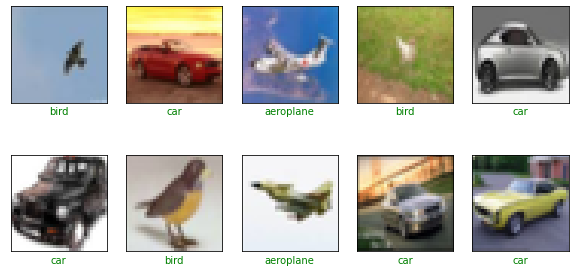

In [ ]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Random Review of Examples 

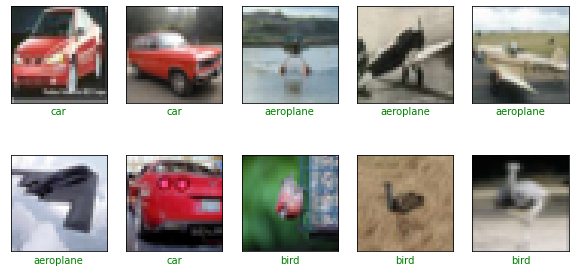

In [ ]:
show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [ ]:
class_names = [['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']]

### Preprocessing the Examples
 The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [ ]:
train_images_norm = train_images.astype('float32')/255.
test_images_norm = test_images.astype('float32')/255.

In [ ]:
train_images_norm.shape, test_images_norm.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Creating Validation Data Set

10,000 samples of our training data to use as a validation set. 

In [ ]:
val_images_norm, train_images_norm = train_images_norm[:10000], train_images_norm[10000:] 
val_labels, train_labels = train_labels[:10000], train_labels[10000:]

In [ ]:
val_images_norm.shape, val_labels.shape

((10000, 32, 32, 3), (10000, 1))

In [ ]:
train_images_norm.shape, train_labels.shape

((40000, 32, 32, 3), (40000, 1))

## Experiments

### Experiment 1

We'll start with a simple DNN with 2 layers and not include any regularization.

In [ ]:
start = datetime.now()
# Build model
model_1 = Sequential([
    Flatten(input_shape = [32,32,3], name = 'input'),
    #Dense(input_shape=(32, 32, 3), units = 256, activation = tf.nn.relu),
    Dense(units = 256, activation = tf.nn.relu),
    Dense(units = 128, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
history_1 = model_1.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_1_time = end - start
print("Elapsed Time: ", model_1_time)

Epoch 1/20
79/79 [==============================] - 1s 10ms/step - loss: 2.2300 - accuracy: 0.2018 - val_loss: 1.9268 - val_accuracy: 0.3021
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 1.8700 - accuracy: 0.3343 - val_loss: 1.8684 - val_accuracy: 0.3030
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 1.7912 - accuracy: 0.3656 - val_loss: 1.7079 - val_accuracy: 0.3938
Epoch 4/20
79/79 [==============================] - 0s 5ms/step - loss: 1.6966 - accuracy: 0.4015 - val_loss: 1.7540 - val_accuracy: 0.3755
Epoch 5/20
79/79 [==============================] - 0s 5ms/step - loss: 1.6667 - accuracy: 0.4068 - val_loss: 1.6576 - val_accuracy: 0.4102
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 1.6347 - accuracy: 0.4201 - val_loss: 1.6370 - val_accuracy: 0.4144
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 1.5928 - accuracy: 0.4346 - val_loss: 1.6202 - val_accuracy: 0.4223
Epoch 8/20
79/79 [=

### Experiment 2

We'll also create a DNN with 3 layers

In [ ]:
start = datetime.now()
# Build model
model_2 = Sequential([
    Flatten(input_shape = [32, 32, 3], name = 'input'),
    Dense(units = 512, activation = tf.nn.relu),
    Dense(units = 256, activation = tf.nn.relu),
    Dense(units = 128, activation = tf.nn.relu),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Flatten)              (None, 3072)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
history_2 = model_2.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_2_time = end - start
print("Elapsed Time: ", model_2_time)

Epoch 1/20
79/79 [==============================] - 1s 8ms/step - loss: 2.2909 - accuracy: 0.1862 - val_loss: 1.8815 - val_accuracy: 0.3256
Epoch 2/20
79/79 [==============================] - 0s 5ms/step - loss: 1.8579 - accuracy: 0.3371 - val_loss: 1.7611 - val_accuracy: 0.3801
Epoch 3/20
79/79 [==============================] - 0s 5ms/step - loss: 1.7319 - accuracy: 0.3869 - val_loss: 1.7323 - val_accuracy: 0.3774
Epoch 4/20
79/79 [==============================] - 0s 5ms/step - loss: 1.6887 - accuracy: 0.4007 - val_loss: 1.6057 - val_accuracy: 0.4243
Epoch 5/20
79/79 [==============================] - 1s 7ms/step - loss: 1.6125 - accuracy: 0.4315 - val_loss: 1.6196 - val_accuracy: 0.4169
Epoch 6/20
79/79 [==============================] - 0s 5ms/step - loss: 1.5752 - accuracy: 0.4359 - val_loss: 1.6046 - val_accuracy: 0.4266
Epoch 7/20
79/79 [==============================] - 0s 5ms/step - loss: 1.5482 - accuracy: 0.4510 - val_loss: 1.5908 - val_accuracy: 0.4328
Epoch 8/20
79/79 [==

### Experiment 3

Now we'll build some CNNs to compare to our DNNs. We'll start off with a CNN with 2 convolutional layers

In [ ]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_3.add(layers.MaxPooling2D((2, 2),strides=2))
model_3.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_3.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(units=512, activation=tf.nn.relu))
model_3.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
# Compile
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
start = datetime.now()
history_3 = model_3.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_3_time = end - start
print("Elapsed Time: ", model_3_time)

Epoch 1/20
79/79 [==============================] - 7s 69ms/step - loss: 2.0256 - accuracy: 0.2737 - val_loss: 1.4102 - val_accuracy: 0.4910
Epoch 2/20
79/79 [==============================] - 5s 64ms/step - loss: 1.3664 - accuracy: 0.5169 - val_loss: 1.2675 - val_accuracy: 0.5428
Epoch 3/20
79/79 [==============================] - 5s 64ms/step - loss: 1.1925 - accuracy: 0.5781 - val_loss: 1.1960 - val_accuracy: 0.5704
Epoch 4/20
79/79 [==============================] - 5s 64ms/step - loss: 1.0706 - accuracy: 0.6240 - val_loss: 1.0587 - val_accuracy: 0.6258
Epoch 5/20
79/79 [==============================] - 5s 64ms/step - loss: 0.9837 - accuracy: 0.6548 - val_loss: 0.9891 - val_accuracy: 0.6558
Epoch 6/20
79/79 [==============================] - 5s 64ms/step - loss: 0.8983 - accuracy: 0.6869 - val_loss: 0.9529 - val_accuracy: 0.6687
Epoch 7/20
79/79 [==============================] - 5s 64ms/step - loss: 0.8364 - accuracy: 0.7134 - val_loss: 0.9208 - val_accuracy: 0.6836
Epoch 8/20
79

### Experiment 4

Next a CNN with 3 convolutional layers

In [ ]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_4.add(layers.MaxPooling2D((2, 2),strides=2))
model_4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_4.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_4.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_4.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_4.add(layers.Flatten())
model_4.add(layers.Dense(units=512, activation=tf.nn.relu))
model_4.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 1024)        4719616   
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)             

In [ ]:
# Compile
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
start = datetime.now()
history_4 = model_4.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_4_time = end - start
print("Elapsed Time: ", model_4_time)

Epoch 1/20
79/79 [==============================] - 8s 88ms/step - loss: 2.0908 - accuracy: 0.2143 - val_loss: 1.5684 - val_accuracy: 0.4201
Epoch 2/20
79/79 [==============================] - 7s 84ms/step - loss: 1.4446 - accuracy: 0.4733 - val_loss: 1.3422 - val_accuracy: 0.5206
Epoch 3/20
79/79 [==============================] - 7s 83ms/step - loss: 1.2209 - accuracy: 0.5704 - val_loss: 1.1465 - val_accuracy: 0.5905
Epoch 4/20
79/79 [==============================] - 7s 83ms/step - loss: 1.0323 - accuracy: 0.6381 - val_loss: 1.1964 - val_accuracy: 0.5771
Epoch 5/20
79/79 [==============================] - 7s 83ms/step - loss: 0.9543 - accuracy: 0.6658 - val_loss: 0.9309 - val_accuracy: 0.6769
Epoch 6/20
79/79 [==============================] - 7s 83ms/step - loss: 0.8157 - accuracy: 0.7168 - val_loss: 0.9460 - val_accuracy: 0.6676
Epoch 7/20
79/79 [==============================] - 7s 83ms/step - loss: 0.7534 - accuracy: 0.7354 - val_loss: 0.8044 - val_accuracy: 0.7206
Epoch 8/20
79

We can see that we are definitely over fitting. Going from 2 to 3 Conv layers increased our training accuracy from ~92% to 97% but our validation accuracy didn't change at all as expected when overfitting.

It is also very obvious that CNNs perform much better for this type of task than DNNs. The accuracy for the CNNs is well above the DNNs.

### Experiment 5

In the following sections we'll start using some regularization techniques to see the effects they have on our accuracy. In this experiment we'll test out adding dropout. We'll use the same model from Experiment 3 since that wasn't overfitting as bad.

In [ ]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_5.add(layers.MaxPooling2D((2, 2),strides=2))
model_5.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_5.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_5.add(layers.Flatten())
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(units=512, activation=tf.nn.relu))
model_5.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout (Dropout)            (None, 18432)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)              

In [ ]:
# Compile
model_5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
start = datetime.now()
history_5 = model_5.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_5_time = end - start
print("Elapsed Time: ", model_5_time)

Epoch 1/20
79/79 [==============================] - 6s 67ms/step - loss: 1.9510 - accuracy: 0.2862 - val_loss: 1.4463 - val_accuracy: 0.4812
Epoch 2/20
79/79 [==============================] - 5s 65ms/step - loss: 1.3391 - accuracy: 0.5232 - val_loss: 1.2702 - val_accuracy: 0.5442
Epoch 3/20
79/79 [==============================] - 5s 65ms/step - loss: 1.1790 - accuracy: 0.5865 - val_loss: 1.0810 - val_accuracy: 0.6280
Epoch 4/20
79/79 [==============================] - 5s 65ms/step - loss: 1.0560 - accuracy: 0.6290 - val_loss: 0.9955 - val_accuracy: 0.6469
Epoch 5/20
79/79 [==============================] - 5s 65ms/step - loss: 0.9575 - accuracy: 0.6656 - val_loss: 0.9723 - val_accuracy: 0.6585
Epoch 6/20
79/79 [==============================] - 5s 65ms/step - loss: 0.9045 - accuracy: 0.6840 - val_loss: 0.8573 - val_accuracy: 0.7033
Epoch 7/20
79/79 [==============================] - 5s 65ms/step - loss: 0.8365 - accuracy: 0.7104 - val_loss: 0.8461 - val_accuracy: 0.7037
Epoch 8/20
79

### Experiment 6

Experiment 5 showed a strong improvement. Let's stick with dropout and see what effect changing the kernel size has. Typically values are (3,3) and (5,5) so lets see how increasing it to 5 changes the accuracy.

In [ ]:
model_6 = models.Sequential()
model_6.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_6.add(layers.MaxPooling2D((2, 2),strides=2))
model_6.add(layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(1, 1), activation=tf.nn.relu))
model_6.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_6.add(layers.Flatten())
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(units=512, activation=tf.nn.relu))
model_6.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_6.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 256)       19456     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 512)       3277312   
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12800)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)              

In [ ]:
# Compile
model_6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
start = datetime.now()
history_6 = model_6.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_6_time = end - start
print("Elapsed Time: ", model_6_time)

Epoch 1/20
79/79 [==============================] - 7s 75ms/step - loss: 2.1461 - accuracy: 0.2107 - val_loss: 1.4869 - val_accuracy: 0.4557
Epoch 2/20
79/79 [==============================] - 5s 68ms/step - loss: 1.4951 - accuracy: 0.4579 - val_loss: 1.3163 - val_accuracy: 0.5249
Epoch 3/20
79/79 [==============================] - 5s 68ms/step - loss: 1.3356 - accuracy: 0.5214 - val_loss: 1.2398 - val_accuracy: 0.5509
Epoch 4/20
79/79 [==============================] - 5s 68ms/step - loss: 1.2329 - accuracy: 0.5631 - val_loss: 1.1999 - val_accuracy: 0.5871
Epoch 5/20
79/79 [==============================] - 5s 69ms/step - loss: 1.1668 - accuracy: 0.5900 - val_loss: 1.1369 - val_accuracy: 0.6031
Epoch 6/20
79/79 [==============================] - 5s 69ms/step - loss: 1.0868 - accuracy: 0.6178 - val_loss: 1.1358 - val_accuracy: 0.6098
Epoch 7/20
79/79 [==============================] - 5s 68ms/step - loss: 1.0209 - accuracy: 0.6419 - val_loss: 1.0256 - val_accuracy: 0.6399
Epoch 8/20
79

### Experiment 7

We saw no marginal increase in accuracy by changing the kernel size in Experiment 6 so lets change it back to (3, 3) and see what effect increasing the stride has.

In [ ]:
model_7 = models.Sequential()
model_7.add(layers.Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_7.add(layers.MaxPooling2D((2, 2),strides=2))
model_7.add(layers.Conv2D(filters=512, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu))
model_7.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_7.add(layers.Flatten())
model_7.add(layers.Dropout(0.5))
model_7.add(layers.Dense(units=512, activation=tf.nn.relu))
model_7.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_7.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 14, 14, 256)       19456     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 512)         3277312   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)              

In [ ]:
# Compile
model_7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
start = datetime.now()
history_7 = model_7.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_7_time = end - start
print("Elapsed Time: ", model_7_time)

Epoch 1/20
79/79 [==============================] - 3s 35ms/step - loss: 2.0999 - accuracy: 0.2038 - val_loss: 1.6269 - val_accuracy: 0.4045
Epoch 2/20
79/79 [==============================] - 3s 32ms/step - loss: 1.6065 - accuracy: 0.4047 - val_loss: 1.4654 - val_accuracy: 0.4602
Epoch 3/20
79/79 [==============================] - 3s 32ms/step - loss: 1.4591 - accuracy: 0.4671 - val_loss: 1.3466 - val_accuracy: 0.5146
Epoch 4/20
79/79 [==============================] - 3s 32ms/step - loss: 1.3461 - accuracy: 0.5133 - val_loss: 1.2866 - val_accuracy: 0.5361
Epoch 5/20
79/79 [==============================] - 3s 32ms/step - loss: 1.2798 - accuracy: 0.5400 - val_loss: 1.2541 - val_accuracy: 0.5588
Epoch 6/20
79/79 [==============================] - 3s 32ms/step - loss: 1.1918 - accuracy: 0.5728 - val_loss: 1.1376 - val_accuracy: 0.5953
Epoch 7/20
79/79 [==============================] - 3s 32ms/step - loss: 1.1294 - accuracy: 0.5984 - val_loss: 1.0916 - val_accuracy: 0.6113
Epoch 8/20
79

### Experiment 8

Experiment 5 still seems to be our best. Let's use it but add an extra Conv2d layer before each pooling step to see how that performs.

In [ ]:
model_8 = models.Sequential()
model_8.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_8.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_8.add(layers.MaxPooling2D((2, 2),strides=2))
model_8.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_8.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_8.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_8.add(layers.Flatten())
model_8.add(layers.Dropout(0.5))
model_8.add(layers.Dense(units=512, activation=tf.nn.relu))
model_8.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_8.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 512)       1180160   
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 512)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 12, 12, 512)       2359808   
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 10, 10, 512)       2359808   
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 5, 5, 512)         0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 12800)           

In [ ]:
# Compile
model_8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# Fit
start = datetime.now()
history_8 = model_8.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                   
                   )


end = datetime.now()
model_8_time = end - start
print("Elapsed Time: ", model_8_time)

Epoch 1/20
79/79 [==============================] - 24s 259ms/step - loss: 2.2623 - accuracy: 0.1783 - val_loss: 1.6226 - val_accuracy: 0.3983
Epoch 2/20
79/79 [==============================] - 19s 241ms/step - loss: 1.5565 - accuracy: 0.4280 - val_loss: 1.3873 - val_accuracy: 0.4916
Epoch 3/20
79/79 [==============================] - 19s 241ms/step - loss: 1.3441 - accuracy: 0.5139 - val_loss: 1.1944 - val_accuracy: 0.5730
Epoch 4/20
79/79 [==============================] - 19s 241ms/step - loss: 1.1632 - accuracy: 0.5871 - val_loss: 1.0360 - val_accuracy: 0.6350
Epoch 5/20
79/79 [==============================] - 19s 241ms/step - loss: 1.0155 - accuracy: 0.6441 - val_loss: 0.9649 - val_accuracy: 0.6588
Epoch 6/20
79/79 [==============================] - 19s 241ms/step - loss: 0.9185 - accuracy: 0.6766 - val_loss: 0.8391 - val_accuracy: 0.7052
Epoch 7/20
79/79 [==============================] - 19s 241ms/step - loss: 0.8152 - accuracy: 0.7115 - val_loss: 0.8486 - val_accuracy: 0.7013

## Experiment 9
Data augmentation: let's see how augmenting our images improves our accuracy. 

Source for help with augmentation code: Deep Learning with Keras:

Gulli, A & Sujit, P. (2017). Deep Learning with Keras. Packt Publishing<br>
https://learning.oreilly.com/library/view/deep-learning-with/9781787128422/1c0ae7dd-bea7-4af8-a08e-82b5eac072f2.xhtml

In [ ]:
# Creating one hot encoded labels
train_labels_cat = to_categorical(train_labels, 10)
val_labels_cat = to_categorical(val_labels, 10)
test_labels_cat = to_categorical(test_labels, 10)

In [ ]:
# Augumenting
datagen = ImageDataGenerator(
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest')

In [ ]:
#fit the dataget
datagen.fit(train_images_norm)

Running Experiment 5 model on our augmented data

In [ ]:
model_9 = models.Sequential()
model_9.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model_9.add(layers.MaxPooling2D((2, 2),strides=2))
model_9.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_9.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model_9.add(layers.Flatten())
model_9.add(layers.Dropout(0.5))
model_9.add(layers.Dense(units=512, activation=tf.nn.relu))
model_9.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model_9.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 6, 6, 512)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)              

In [ ]:
# Compile - this time with Categorical Crossentropy
model_9.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# training with generator
start = datetime.now()

history_9 = model_9.fit_generator(datagen.flow(train_images_norm, train_labels_cat), 
epochs=20, 
validation_data=(val_images_norm, val_labels_cat))

end = datetime.now()
model_9_time = end - start
print("Elapsed Time: ", model_9_time)

Epoch 1/20
1250/1250 [==============================] - 20s 15ms/step - loss: 1.9587 - accuracy: 0.2654 - val_loss: 1.5562 - val_accuracy: 0.4378
Epoch 2/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.6510 - accuracy: 0.3990 - val_loss: 1.3412 - val_accuracy: 0.5178
Epoch 3/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.5440 - accuracy: 0.4413 - val_loss: 1.2224 - val_accuracy: 0.5649
Epoch 4/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.4861 - accuracy: 0.4610 - val_loss: 1.2252 - val_accuracy: 0.5705
Epoch 5/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.4587 - accuracy: 0.4721 - val_loss: 1.2158 - val_accuracy: 0.5735
Epoch 6/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.4113 - accuracy: 0.4934 - val_loss: 1.1672 - val_accuracy: 0.5842
Epoch 7/20
1250/1250 [==============================] - 19s 15ms/step - loss: 1.3754 - accuracy: 0.5029 - val_loss: 1.1454 -

## Experiment 10
In our last experiment with data augmentation we saw that our validation accuracy went way down. The interesting part was that our training accuracy went down even more. It seems that we're now underfitting. Lets repeat the same experiment but this time with a more complex model.<br>
We'll start with simply allowing it to run for more iterations (epochs) to see if that increases the accuracy.

In [ ]:
# training with generator
start = datetime.now()

history_10 = model_9.fit_generator(datagen.flow(train_images_norm, train_labels_cat), 
epochs=100, 
validation_data=(val_images_norm, val_labels_cat))

end = datetime.now()
model_10_time = end - start
print("Elapsed Time: ", model_10_time)

Epoch 1/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1945 - accuracy: 0.5755 - val_loss: 0.9296 - val_accuracy: 0.6721
Epoch 2/100
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1842 - accuracy: 0.5791 - val_loss: 0.9427 - val_accuracy: 0.6768
Epoch 3/100
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1784 - accuracy: 0.5802 - val_loss: 1.0462 - val_accuracy: 0.6379
Epoch 4/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1728 - accuracy: 0.5835 - val_loss: 0.9345 - val_accuracy: 0.6725
Epoch 5/100
1250/1250 [==============================] - 19s 15ms/step - loss: 1.1658 - accuracy: 0.5875 - val_loss: 1.0191 - val_accuracy: 0.6433
Epoch 6/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1658 - accuracy: 0.5875 - val_loss: 0.9619 - val_accuracy: 0.6635
Epoch 7/100
1250/1250 [==============================] - 20s 16ms/step - loss: 1.1553 - accuracy: 0.5915 - val_loss: 0

In [ ]:
history_dict = history_10.history
history_dict.keys()

losses = history_10.history['loss']
accs = history_10.history['accuracy']
val_losses = history_10.history['val_loss']
val_accs = history_10.history['val_accuracy']
epochs = len(losses)

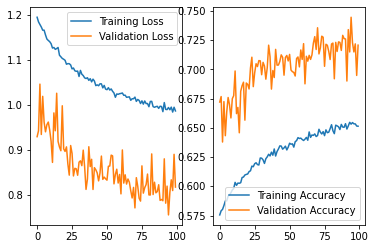

In [ ]:
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Experiment 11

In our last experiment we'll use a pretrained model that was trained on the ImageNet data. We'll pull one directly from Keras and use the trained weights in the lower layers while still adding and training our own dense upper layers (just like we have on previous models). We'll use augmented data as well.

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
# Adding new dense layers on top of our pretrained model
model_11 = models.Sequential()
model_11.add(conv_base)
model_11.add(layers.Flatten())
model_11.add(layers.Dropout(0.5))
model_11.add(layers.Dense(units=512, activation=tf.nn.relu))
model_11.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
conv_base.trainable = False

In [ ]:
model_11.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_7 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                5130      
Total params: 14,982,474
Trainable params: 267,786
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
# Compile
from keras import optimizers
model_11.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Compile - this time with Categorical Crossentropy
model_11.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
# training with generator
start = datetime.now()

history_11 = model_11.fit_generator(datagen.flow(train_images_norm, train_labels_cat), 
epochs=20, 
validation_data=(val_images_norm, val_labels_cat))

end = datetime.now()
model_11_time = end - start
print("Elapsed Time: ", model_11_time)

Epoch 1/20
1250/1250 [==============================] - 21s 16ms/step - loss: 1.9361 - accuracy: 0.3043 - val_loss: 1.5285 - val_accuracy: 0.4794
Epoch 2/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7533 - accuracy: 0.3750 - val_loss: 1.5076 - val_accuracy: 0.4918
Epoch 3/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.7182 - accuracy: 0.3841 - val_loss: 1.4758 - val_accuracy: 0.4974
Epoch 4/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6982 - accuracy: 0.3967 - val_loss: 1.4750 - val_accuracy: 0.5078
Epoch 5/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6777 - accuracy: 0.4010 - val_loss: 1.4577 - val_accuracy: 0.5196
Epoch 6/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6692 - accuracy: 0.4058 - val_loss: 1.4279 - val_accuracy: 0.5215
Epoch 7/20
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6620 - accuracy: 0.4071 - val_loss: 1.3979 -

This performed pretty poorly. I think this has to do with the fact that this model was trained using much more detailed images (224x224) and our CIFAR10 data is much less detailed at 32x32. 

## Comparing the Results of our Experiments
Here we'll tabularize everything and see how all of the experiments compared.

In [ ]:
# Comparing the accuracy of all of our models on the test set

# Important note: There isn't a model 10, experiment 10 was just running model 9 for more epochs so in the results below 
# I omit the number 10. Don't be confused when looking at the graphs because 10 is missing.

train_acc = []
total_acc = []
total_loss = []
total_time = []
x = []

for i in range(1,12):
  if i == 10: # since there is no model 10
    continue
  else:
    x.append(i)
    total_time.append(eval("model_" + str(i) + "_time"))
    try:
      loss, accuracy = eval("model_" + str(i) + ".evaluate(test_images_norm, test_labels)")
      train_loss, train_accuracy = eval("model_" + str(i) + ".evaluate(train_images_norm, train_labels)")
    except:
      loss, accuracy = eval("model_" + str(i) + ".evaluate(test_images_norm, test_labels_cat)")
      train_loss, train_accuracy = eval("model_" + str(i) + ".evaluate(train_images_norm, train_labels_cat)")

  total_acc.append(accuracy)
  total_loss.append(loss)
  train_acc.append(train_accuracy)


1250/1250 [==============================] - 8s 6ms/step - loss: 1.3736 - accuracy: 0.5316


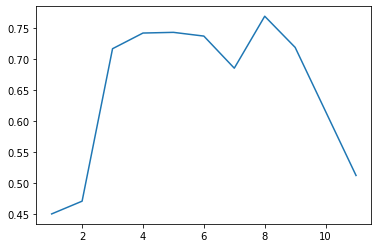

In [ ]:
# Plotting Accuracy
plt.plot(x, total_acc)

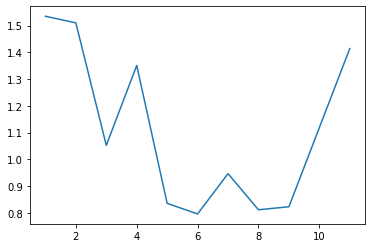

In [ ]:
# Plotting Loss
plt.plot(x, total_loss)

In [ ]:
# Checking Times
for item in range(len(total_time)):
  print("Model ", x[item], ":\t", total_time[item])

Model  1 :	 0:00:09.842952
Model  2 :	 0:00:09.422274
Model  3 :	 0:01:43.990289
Model  4 :	 0:02:12.782689
Model  5 :	 0:01:43.393654
Model  6 :	 0:01:49.703180
Model  7 :	 0:00:51.553847
Model  8 :	 0:06:25.597001
Model  9 :	 0:06:28.088177
Model  11 :	 0:06:45.668837


In [ ]:
print("Model with Max Accuracy: \t", np.argmax(total_acc, axis=-1)+1)
print("Model with Min Loss: \t\t", np.argmin(total_loss, axis=-1)+1)
print("Model with Fastest Time: \t", np.argmin(total_time, axis=-1)+1)


Model with Max Accuracy: 	 8
Model with Min Loss: 		 6
Model with Fastest Time: 	 2


Now let's look at all of the models together in a tabular format across all metrics:

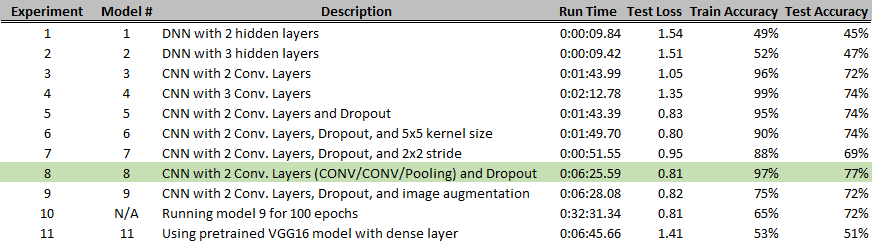

## Visualizing the Layers
In this section we'll take a look at experiment 3 and dig in to see what parts of the images are lighting up in the two hidden layers.

In [ ]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model_3.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_3.input, outputs=layer_outputs)

In [ ]:
# Prepping a test image into the necessary shape
img_tensor = image.img_to_array(test_images_norm[11])
img_tensor = np.expand_dims(img_tensor, axis=0)

print(img_tensor.shape)

(1, 32, 32, 3)


In [ ]:
activations = activation_model.predict(img_tensor)

In [ ]:
# The 4 layers of our model
len(activations)

4

In [ ]:
# Checking the shape of our 4 layers
# These match what we saw in the model 3 summary for the output shape of the first 4 layers
for i in range(len(activations)):
  print(activations[i].shape)

(1, 30, 30, 256)
(1, 15, 15, 256)
(1, 13, 13, 512)
(1, 6, 6, 512)


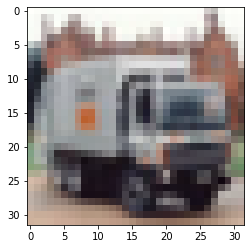

In [ ]:
# Showing original test image for reference
plt.imshow(test_images_norm[11])
plt.show()

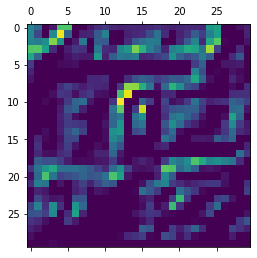

In [ ]:
# Testing out a random channel in the first layer
plt.matshow(activations[0][0, :, :, random.randint(0,activations[0].shape[3])], cmap='viridis')
plt.show()

Now lets look at all of the channels in our 4 layers to see how they compare.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


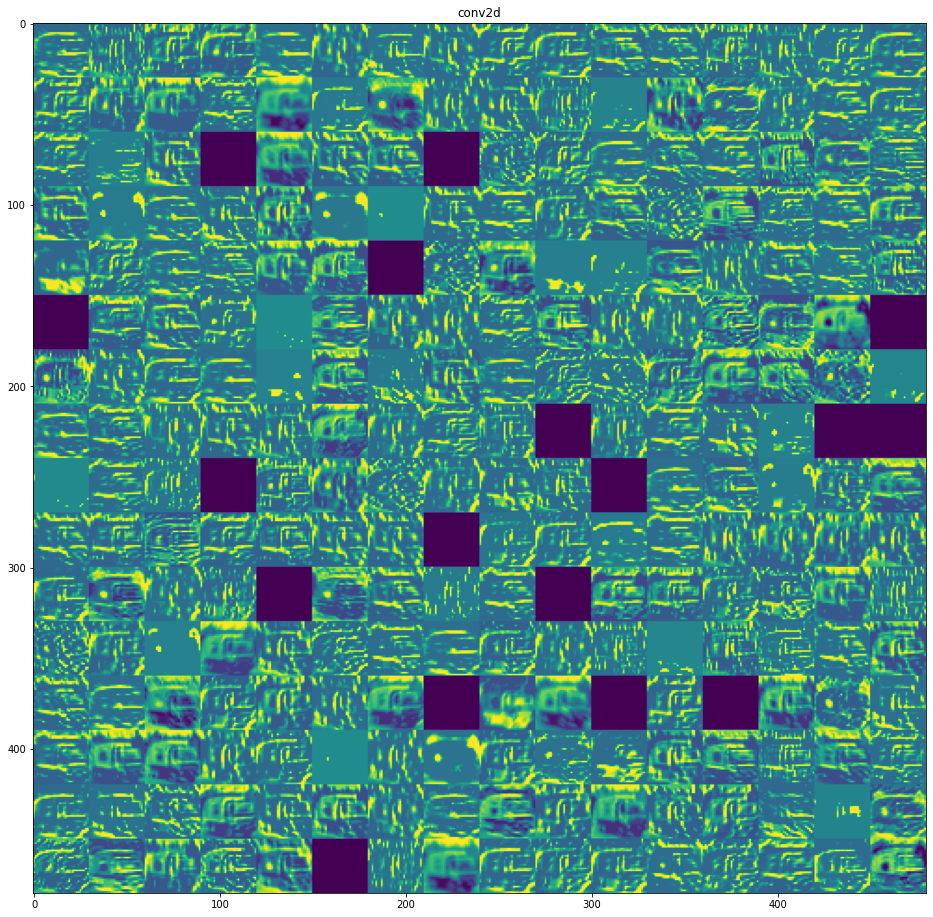

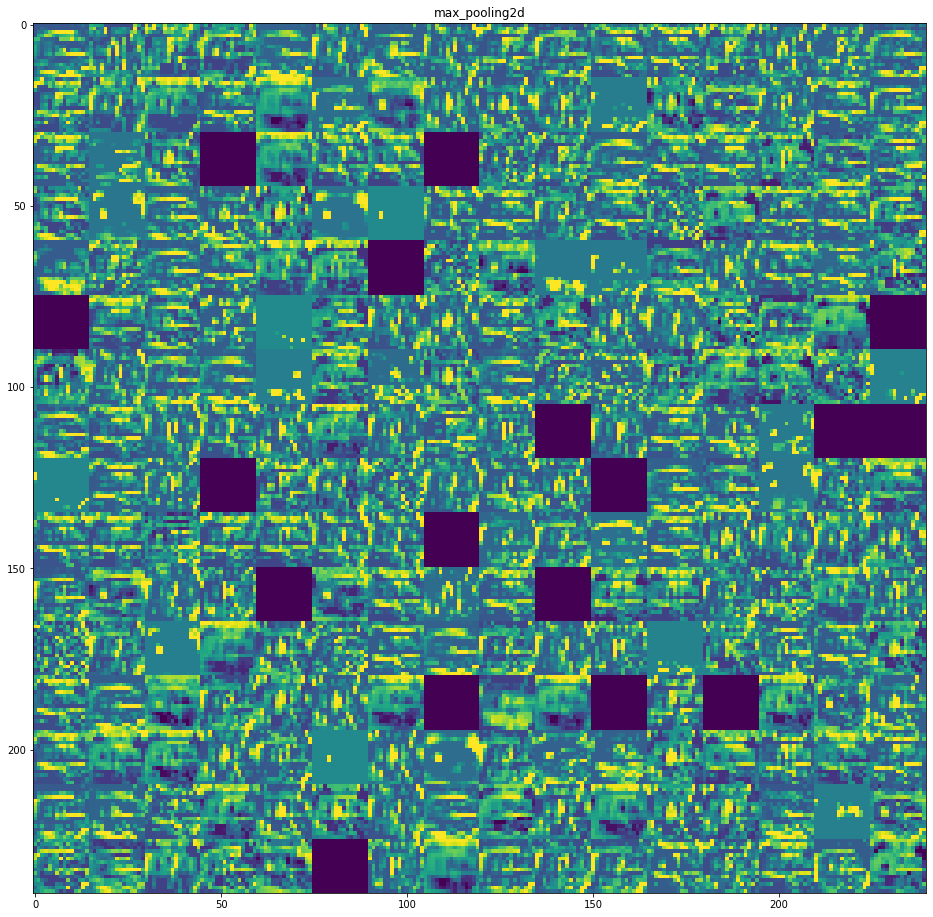

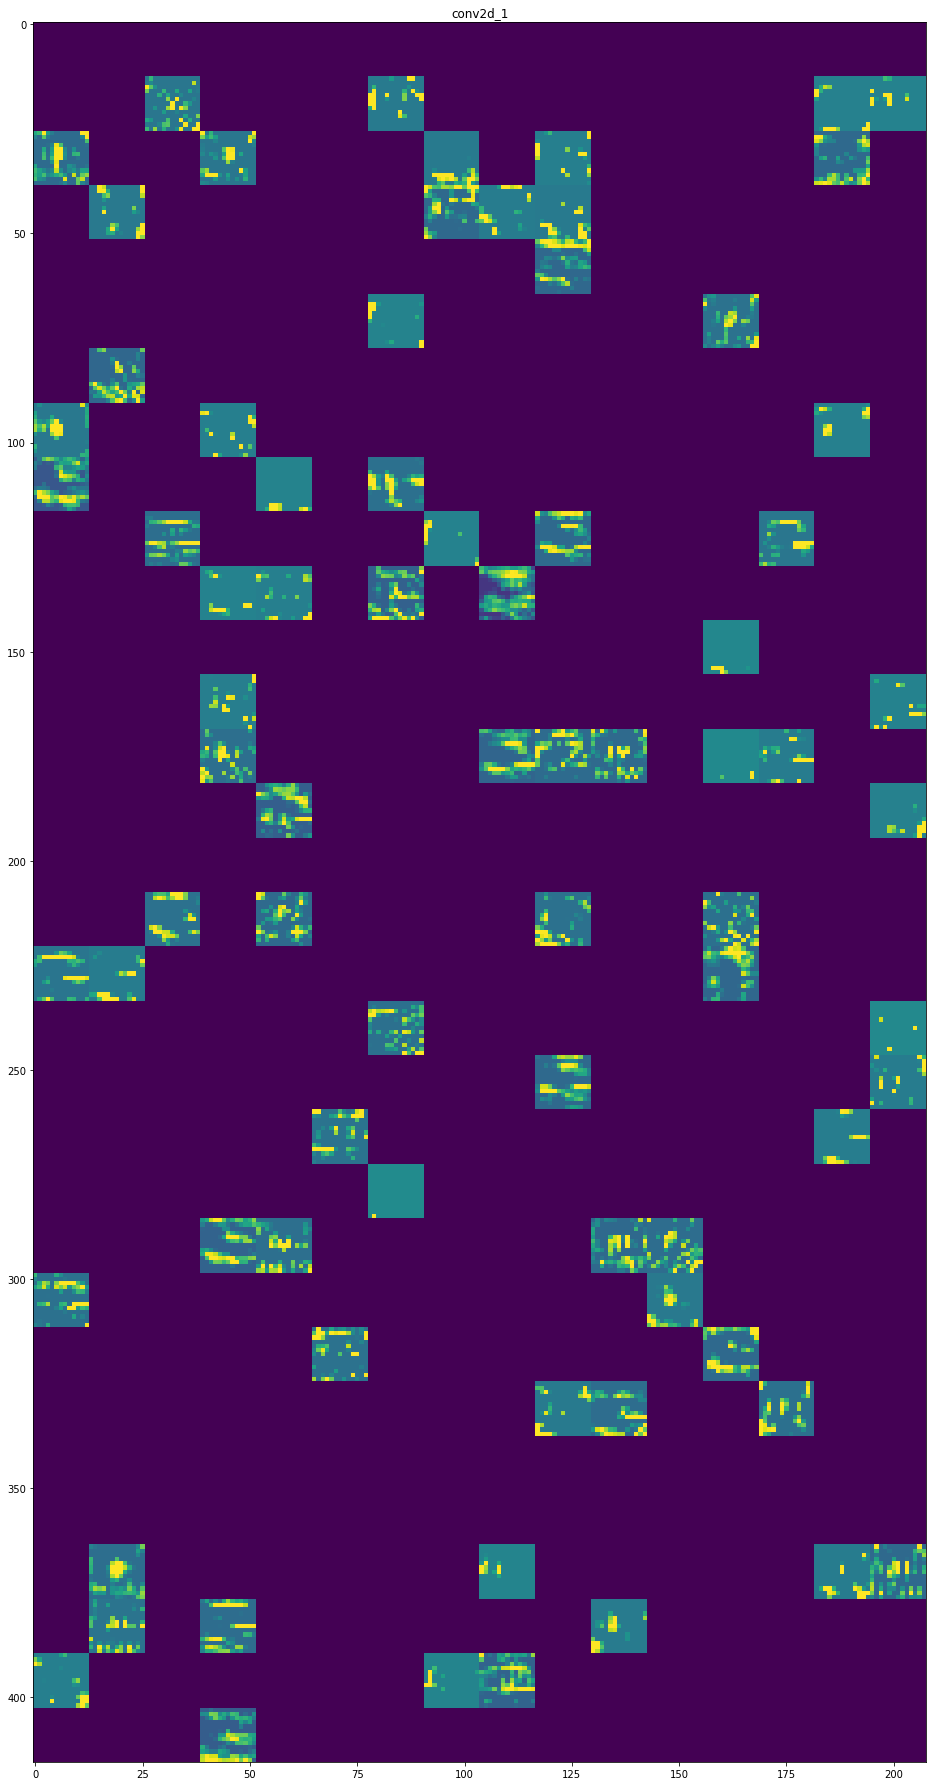

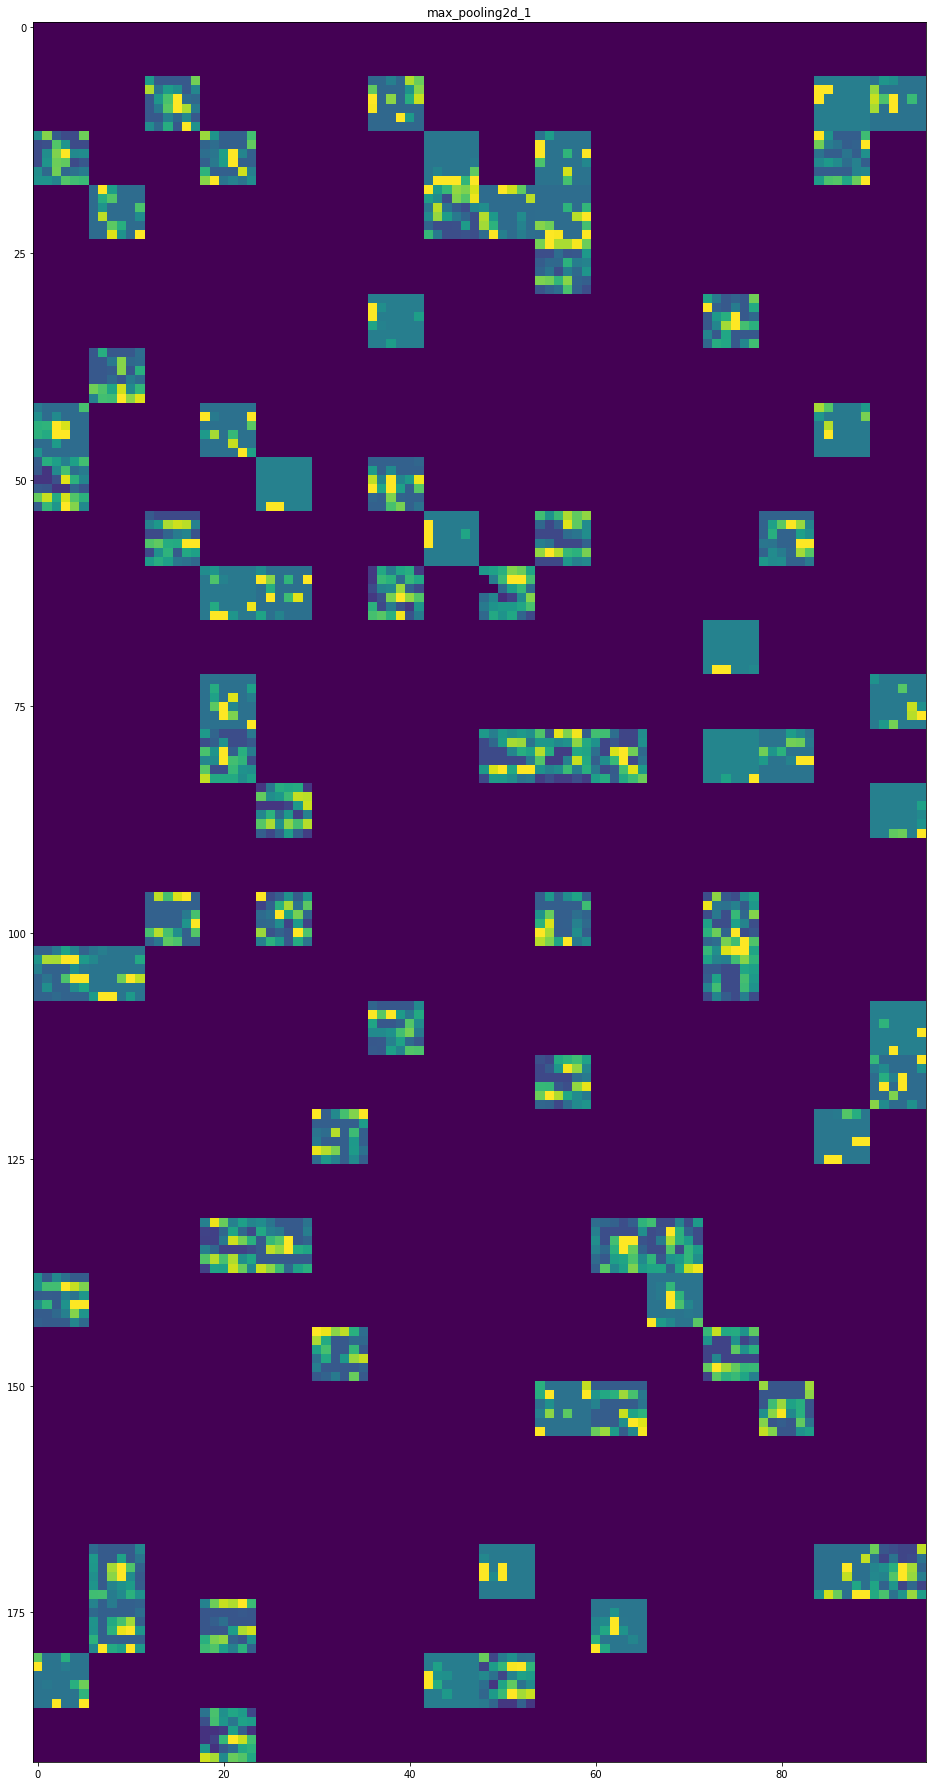

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model_3.layers[:4]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

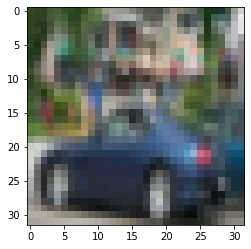

122


In [ ]:
# Grabbing a random picture
a = random.randint(0,200)

plt.imshow(test_images_norm[a])
plt.show()
print(a)

## T-SNE to Visualize our Best Model
Here we will use T-SNE to view our classes in a two dimensional space and comfirm that we have adequate class separation. <br>
Our best model was from Experiment 8. We'll use that here in the visualization.

In [ ]:
# Get the predicted classes:
pred_classes = np.argmax(model_8.predict([train_images_norm[0:1000]]), axis=-1)

In [ ]:
# Extracts the outputs of the layers:
layer_outputs = [layer.output for layer in model_8.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model_8.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")

There are 10 layers


In [ ]:
# Get the outputs of the training images
activations = activation_model.predict(train_images_norm[0:1000])
hidden_layer_activation = activations[8]
output_layer_activations = activations[9]
hidden_layer_activation.shape   

(1000, 512)

In [ ]:
#Get the dataframe of all the node values
activation_data = {'pred_class':pred_classes}
for k in range(0,512): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)

In [ ]:
N=10000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(1000, 513)

In [ ]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
#tsne_results = tsne.fit_transform(data_subset)
tsne_results = tsne.fit_transform(activation_df_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.032s...
[t-SNE] Computed neighbors for 1000 samples in 1.028s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 6.833329
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.142548
[t-SNE] KL divergence after 300 iterations: 1.399929


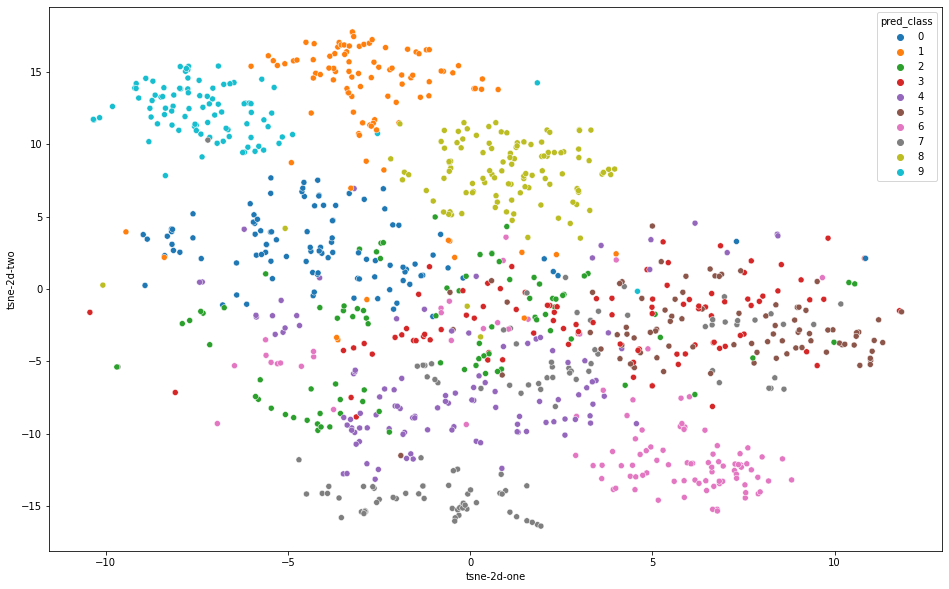

In [ ]:
activation_df_subset['tsne-2d-one'] = tsne_results[:,0]
activation_df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred_class",
    palette=sns.color_palette(None, 10),
    data=activation_df_subset,
    legend="full",
    #alpha=0.3

    #"hls"
)